**Libraries**
==

In [419]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
import random
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

**Load dataset "Images"**
==

In [290]:

root_folder_path = "D:/MO3 LAP/Datasets/for_clustering6"
size = 64
num_of_fruits = 30
samples_of_each_fruit = 20
num_of_images = samples_of_each_fruit*num_of_fruits
images = []
i= 0

folders_list = os.listdir(root_folder_path)
for folder_name in folders_list:
    folder_path = os.path.join(root_folder_path, folder_name)
    if i>= num_of_fruits:
        break
    if os.path.isdir(folder_path):
        #get all images in the folder in one list 
        images_list = [image_name for image_name in os.listdir(folder_path) if image_name.lower()]
        #select samples_of_each_fruit images RANDOMLY 
        selected_images = random.sample(images_list, min(samples_of_each_fruit, len(images_list)))
        
        for image_name in selected_images:
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (size,size))
            images.append(image)
    i+=1
images = np.array(images)
print(images.shape)

(600, 64, 64, 3)


* See some fruits

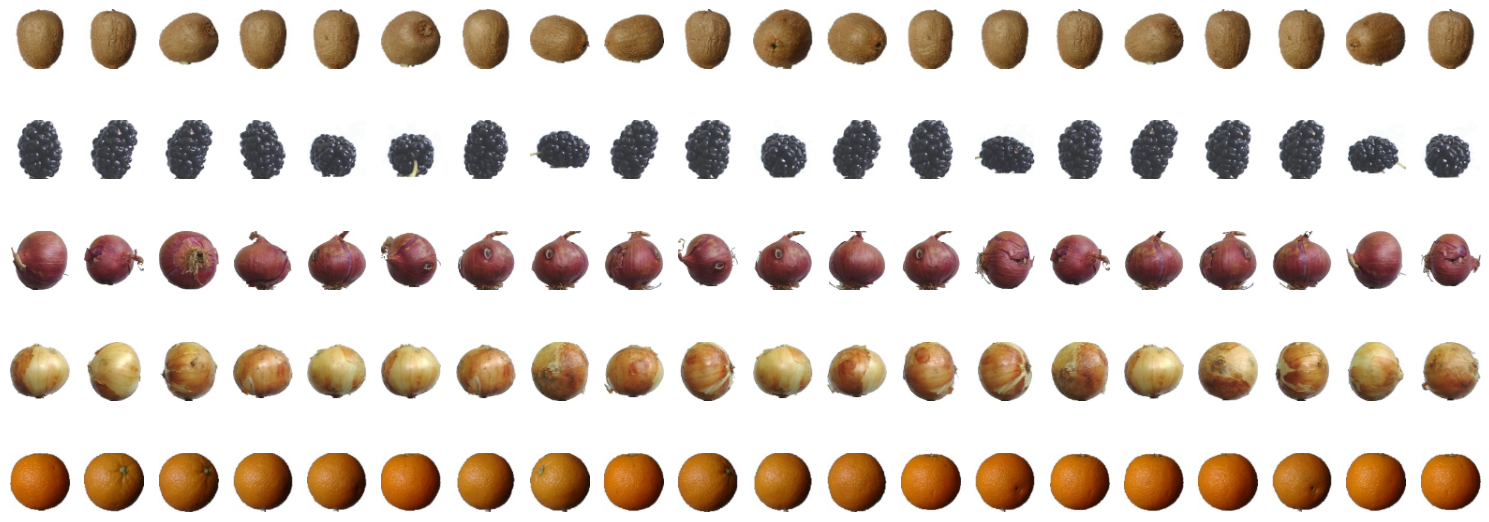

In [442]:
def plot_images(images):
    fig, axs = plt.subplots(5, 20, figsize=(15, 6))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images(images[340:440,:,:,:])

* **Flatten width and height of all images**
 
This is beacuse we will reduct width and height of each example in our dataset.
So, num of features == width * height = 64*64 = 4096 features

In [292]:
flattened_images = images.reshape(num_of_images,size*size,3)

* **Split images...**

We have RGB images so, we will split images to 3 (R,G & B) and apply PCA over each channel seperatly then wi will merge them

In [293]:
r, g, b = cv2.split(flattened_images)

* **Normalize images**


In [294]:
#STEP 1
def Norm_cent(channel):
    channel = channel / 255.0
    mean= np.mean(channel,axis=0)
    Normalized_Centered_channel =channel-mean
    
    return Normalized_Centered_channel,mean

r,rmean= Norm_cent(r)
g,gmean= Norm_cent(g)
b,bmean= Norm_cent(b)

PCA
==

* **Covariance matrix**


In [295]:
def MY__COV(channel):
    covariance_matrix = (1/(num_of_images-1))*np.dot(channel.T,channel)

    return covariance_matrix

* **My PCA function "from scratch"**


In [296]:
def get_EigVecsVals(channel):
    #STEP 2    
    covariance_matrix = MY__COV(channel)
    
    #STEP 3
    # we have 4096,4096 cov matrix, itis so hard to get eigen vectors from it by solving te equation
    # in the best case we will use a built in function that solves equations of very high degree!
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    
    idx = np.argsort(eigenvalues)[::-1] # get indices in ascending and then flip it by(-1) to be in descending order
    eigenvalues = eigenvalues[idx] # do the actual sort for vals
    eigenvectors = eigenvectors[:, idx] #sort for vectors by indices
    

    return eigenvectors,eigenvalues



def MY__PCA(channel,k,mean,eigenvectors):
    k_eigenvectors = eigenvectors[:, :k] #get best k eigenvector, we will change k alot to try different Q matrices

    #STEP 4 
    reduced_image = np.dot(channel, k_eigenvectors)# reduct the image

    #STEP 5
    reconstructed_image = np.dot(reduced_image, k_eigenvectors.T) + mean #we need mean to reposionate the data in itis actual place (UNDO centering)
    
    return reduced_image, reconstructed_image


In [297]:
r_eigenvectors, r_eigenvalues = get_EigVecsVals(r) 
g_eigenvectors, g_eigenvalues = get_EigVecsVals(g)
b_eigenvectors, b_eigenvalues = get_EigVecsVals(b)


* **Plot Variance compared to number of Principle components 'eigen vectors'**

Note that here we can try any k, because all we care about is the eigen values.

Also note that the number K principle components that appears on the x axis represents the reduction from "width,height" to "width,height", so, compare it to 4096 not x_value! 




number of best eigen vecs that holds all the variance 598


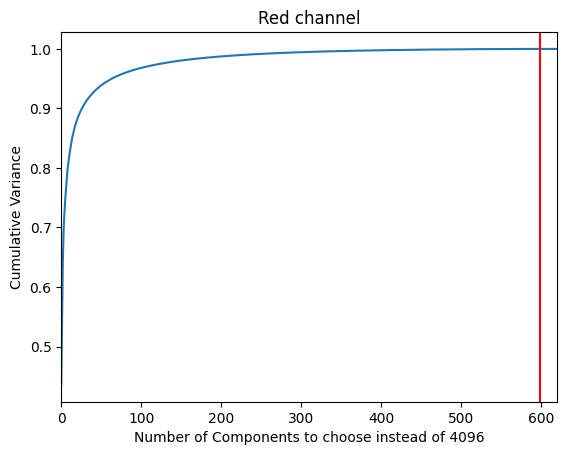

number of best eigen vecs that holds all the variance 598


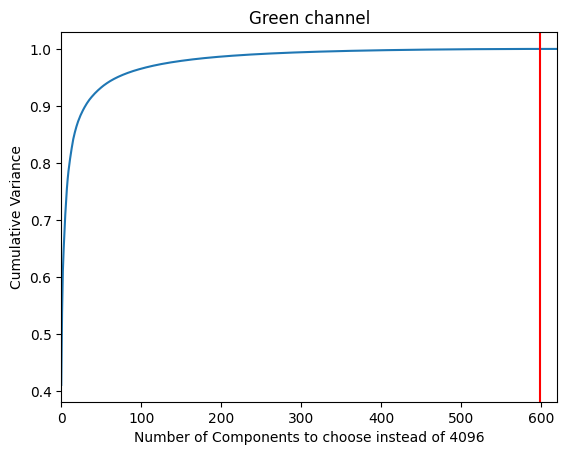

number of best eigen vecs that holds all the variance 598


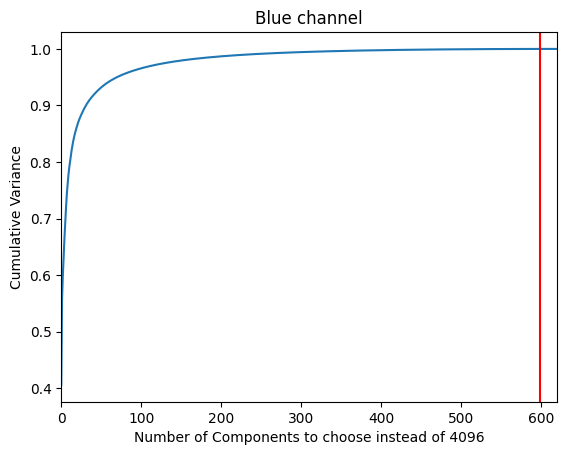

In [316]:
lim = 620
#red
comulative_variance = np.cumsum(r_eigenvalues) / np.sum(r_eigenvalues)
plt.plot(comulative_variance)
plt.xlabel('Number of Components to choose instead of 4096')
plt.ylabel('Cumulative Variance')
plt.xlim(0, lim)#limit the x-axis to the range[0, lim]

#find the x value where the cumulative explained variance first reaches 1.0
x_value = np.argmax(comulative_variance >=0.999999999)
print("number of best eigen vecs that holds all the variance",x_value)
plt.axvline(x=x_value, color='r', linestyle='-')
plt.title("Red channel")
plt.show()

#Green
comulative_variance = np.cumsum(g_eigenvalues) / np.sum(g_eigenvalues)
plt.plot(comulative_variance)
plt.xlabel('Number of Components to choose instead of 4096')
plt.ylabel('Cumulative Variance')
plt.xlim(0, lim)  

x_value = np.argmax(comulative_variance >= 0.999999999)
print("number of best eigen vecs that holds all the variance",x_value)
plt.axvline(x=x_value, color='r', linestyle='-')
plt.title("Green channel")
plt.show()


#Blue
comulative_variance = np.cumsum(b_eigenvalues) / np.sum(b_eigenvalues)
plt.plot(comulative_variance)
plt.xlabel('Number of Components to choose instead of 4096')
plt.ylabel('Cumulative Variance')
plt.xlim(0, lim) 

x_value = np.argmax(comulative_variance >=0.999999999)
print("number of best eigen vecs that holds all the variance",x_value)
plt.axvline(x=x_value, color='r', linestyle='-')
plt.title("Blue channel")
plt.show()




* **Function to use many Q matrices**

this is based on K we choose

In [299]:

def Q_trails(k):
    r_reduced, r_reconstructed = MY__PCA(r, k*k,rmean,r_eigenvectors)
    g_reduced, g_reconstructed = MY__PCA(g, k*k,gmean,g_eigenvectors)
    b_reduced, b_reconstructed = MY__PCA(b, k*k,bmean,b_eigenvectors)

    reduced_images = cv2.merge([r_reduced, g_reduced, b_reduced])
    reconstructed_images = cv2.merge([r_reconstructed, g_reconstructed, b_reconstructed])

    reduced_images = reduced_images.reshape(num_of_images,k,k,3)
    reconstructed_images = reconstructed_images.reshape(num_of_images,size,size,3)

    return reduced_images,reconstructed_images 

* **Apply PCA with different Q matrices**

This is another illustration that make us sure of the last graphs results.

In [300]:
reduced_images_30,reconstructed_images_30 = Q_trails(30)#900

reduced_images_25,reconstructed_images_25 = Q_trails(25)#625

reduced_images_20,reconstructed_images_20 = Q_trails(20)#400

reduced_images_5,reconstructed_images_5 = Q_trails(5)#25

* **Plot samples of a trial**

In [301]:
def plot_images(original_images, reduced_images, reconstructed_images, title):
    fig, ax = plt.subplots(figsize=(2, 1))    
    ax.text(0.5, 0.5, title,fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.axis('off')  # Hide axes
    plt.show()
    first=60
    second=480
    third=320
    fourth=550

    plot1=first
    plot2=second
    for i in range(10,12):
        fig, axes = plt.subplots(1, 6, figsize=(15, 5))  
        
        original = np.clip(original_images[plot1], 0, 255)
        reduced = np.clip(reduced_images[plot1], 0, 1)
        reconstructed = np.clip(reconstructed_images[plot1], 0, 1)

        axes[0].imshow(original)
        axes[0].set_title('Original Image')
        
        axes[1].imshow(reduced)
        axes[1].set_title('Reduced Image')
        
        axes[2].imshow(reconstructed)
        axes[2].set_title('Reconstructed Image')

        original = np.clip(original_images[plot2], 0, 255)
        reduced = np.clip(reduced_images[plot2], 0, 1)
        reconstructed = np.clip(reconstructed_images[plot2], 0, 1)

        axes[3].imshow(original)
        axes[3].set_title('Original Image')
        
        axes[4].imshow(reduced)
        axes[4].set_title('Reduced Image')
        
        axes[5].imshow(reconstructed)
        axes[5].set_title('Reconstructed Image')
        
        
        
        plt.show()

        plot1=third
        plot2=fourth

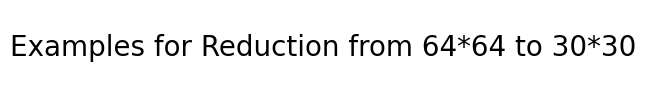

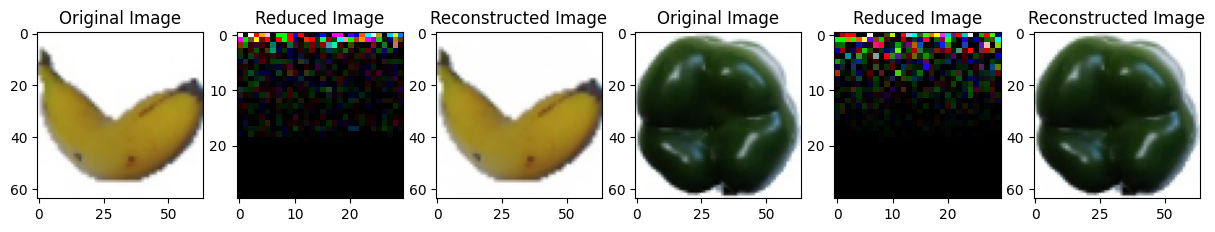

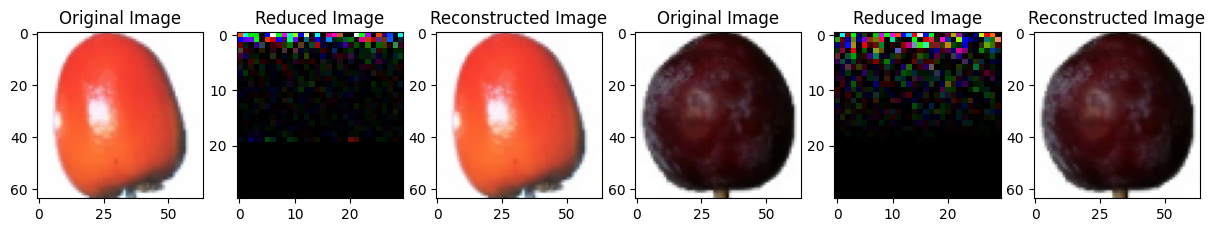

In [302]:
plot_images(images,reduced_images_30,reconstructed_images_30,f"Examples for Reduction from {size}*{size} to 30*30")

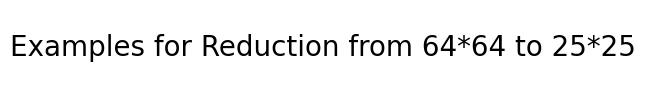

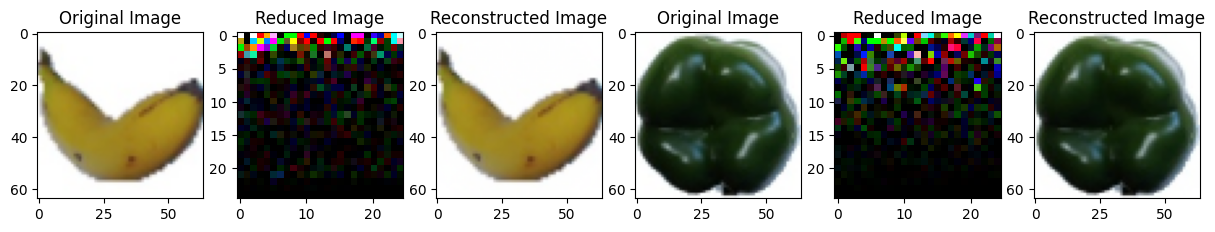

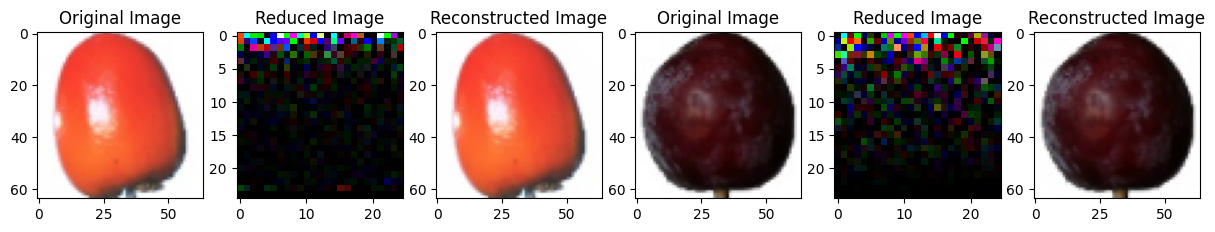

In [303]:
plot_images(images,reduced_images_25,reconstructed_images_25,f"Examples for Reduction from {size}*{size} to 25*25")

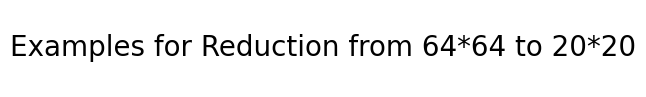

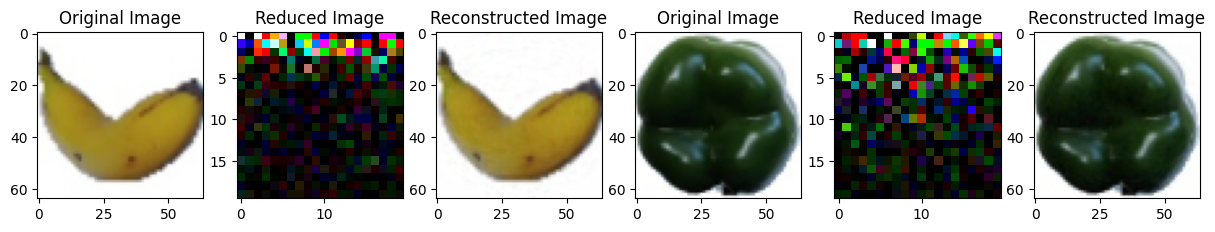

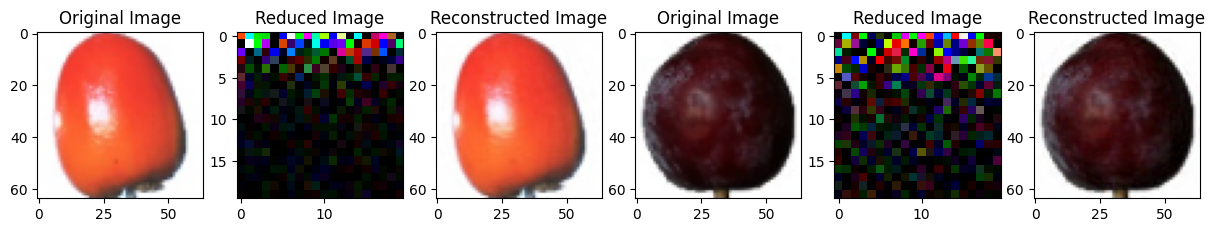

In [304]:
plot_images(images,reduced_images_20,reconstructed_images_20,f"Examples for Reduction from {size}*{size} to 20*20")


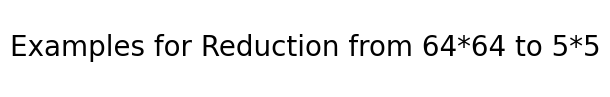

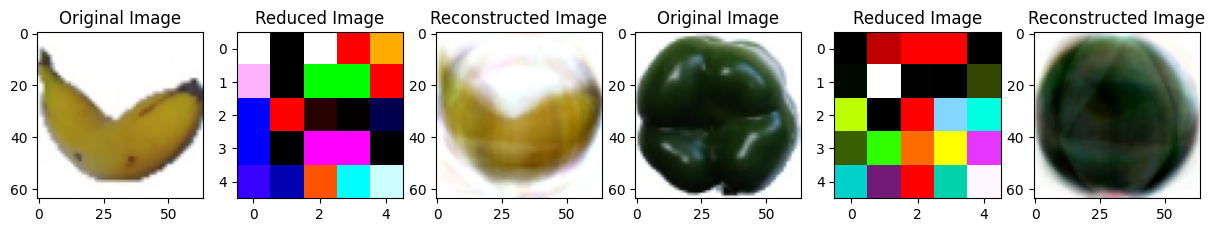

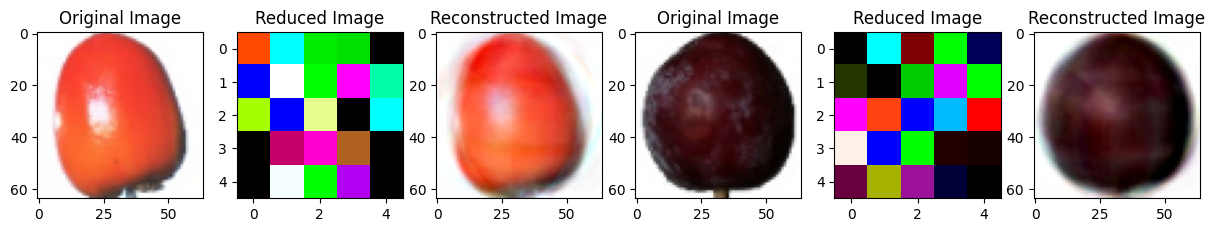

In [305]:
plot_images(images,reduced_images_5,reconstructed_images_5,f"Examples for Reduction from {size}*{size} to 5*5")


---
**PCA REPORT**
==
* As seen above, we have a dataset of **600** fruit images, our aim is to reduce the dimensions '**fearures**' of each image.
* The feauters in this dataset are represented as **width** and **height**, so we kinda merge or **flattened** both of w and h to make them as **one** **features vector**.
* To reduce dimensions we used **PCA** technique but, how to **choose** number of principle components??
* Note that we get reconstructed image from the reduced image, so when reconstructed image looks **more like the original** one thats mean the reduced image is actually has **captured more of the most important features**. 
* We noticed that the variance of the best **598** eigen vectors represents almost **100%** of the total **4096** eigen vectors variances!! 
* That means if we reduct the dims from **4096** to **598** we will still have the **diffrences** that the **clustering algorithm** can use to **cluster** data.
* Now there is a point, if we choose the absolute best eigenvectors it wonot be easy to plot it as squared image, that's why i **took** the best 625 eigen vectore instead, because **sqrt(625) == 25**, so we can reshape the eigenvectors to squared matrix (25,25) and plot it as image! 

* **Based on all above for each  image I Choose the best 625 Eigen vectors to represents the image features 'width & height pixels'.** 


----
**Fuzzy C Means algorithm**
=====
* Data (samples,featurez)
* I need to determine num of clusters before start
* g is the fuzziness, bigger is higher to relate to other centroids than the most close centroid
* eps is the stopping ceiteria
* dirichlet is a distribution that ensure that each row sum is 1 

In [274]:
def fuzzy_c_means(data, num_of_clusters, g, eps=0.0001,max_iter= 1000): 
    M = np.random.dirichlet(np.ones(num_of_clusters), size=len(data))# matrix of shape (len(data), num of clusters)
    while max_iter > 0 :
        #clusters centeroids
        centers = np.dot(M.T**g, data)/np.sum(M.T**g, axis=1, keepdims=True)

        #all Euclidean distances
        dist = np.zeros((len(data), num_of_clusters))
        for i in range(num_of_clusters):
            dist[:, i] = np.linalg.norm(data - centers[i], axis=1)

        #update membership matrix
        new_M = np.zeros_like(M)
        for i in range(num_of_clusters):
            for k in range(len(data)):
                new_M[k, i] = 1. / np.sum((dist[k, i] / dist[k, :])**(2./(g-1)))
        max_iter -= 1

        #stop or not ? 
        if np.linalg.norm(M - new_M) < eps:
            break

        M = new_M

    #Finally choose the cluster of each sample based on itis highest membership value
    clusters = np.argmax(M, axis=1)# 1 because i will choose the highest of each ROW 

    return M, centers, clusters


* **Apply FCM before PCA**
 

In [321]:
original_images = images.reshape(num_of_images,size*size*3)
membership_matrix_before_PCA, centroids_before_PCA, clusters_before_PCA = fuzzy_c_means(original_images, num_of_fruits, 1.3, 1e-100)

* **Apply FCM after PCA from (100,100) to (30,30)**


In [359]:
reduced_images_30 = reduced_images_30.reshape(num_of_images,30*30*3)
membership_matrix_30PC,centroids2_30PC, clusters_30PC = fuzzy_c_means(reduced_images_30, num_of_fruits, 1.3, 1e-10000)


* **Apply FCM after PCA from (100,100) to (25,25)**

In [362]:
reduced_images_25 = reduced_images_25.reshape(num_of_images,25*25*3)
membership_matrix_25PC,centroids_25PC, clusters_25PC = fuzzy_c_means(reduced_images_25, num_of_fruits, 1.2, 1e-10000)

* **Apply FCM after PCA from (100,100) to (20,20)**

In [365]:
reduced_images_20 = reduced_images_20.reshape(num_of_images,20*20*3)
membership_matrix_20PC,centroids_20PC, clusters_20PC = fuzzy_c_means(reduced_images_20, num_of_fruits, 1.2, 1e-10000)


* **Apply FCM after PCA from (100,100) to (5,5)**

In [368]:
reduced_images_5 = reduced_images_5.reshape(num_of_images,5*5*3)
membership_matrix_5PC,centroids_5PC, clusters_5PC = fuzzy_c_means(reduced_images_5, num_of_fruits, 1.2, 1e-10000)

-----
**Mesasures**
==


* **Inertia "Sum of Squared Distances"**

Measures how compact the clusters are. It is the sum of squared distances between data points and their cluster center.

0:inf
   
   --> Lower better

In [378]:
squared_distances = np.sum((original_images - centroids_before_PCA[clusters_before_PCA]) ** 2, axis=1)
inertia = np.sqrt(np.sum(squared_distances))

print("Before PCA Inertia :", int(inertia/64))

Before PCA Inertia : 1608


In [379]:
squared_distances = np.sum((reduced_images_30 - centroids2_30PC[clusters_30PC]) ** 2, axis=1)
inertia = np.sqrt(np.sum(squared_distances))

print("To 30 PC Inertia :", int(inertia/30))

To 30 PC Inertia : 13


In [380]:
squared_distances = np.sum((reduced_images_25 - centroids_25PC[clusters_25PC]) ** 2, axis=1)
inertia = np.sqrt(np.sum(squared_distances))

print("To 25 PC Inertia :", int(inertia/25))

To 25 PC Inertia : 15


In [381]:
squared_distances = np.sum((reduced_images_20 - centroids_20PC[clusters_20PC]) ** 2, axis=1)
inertia = np.sqrt(np.sum(squared_distances))

print("To 20 PC Inertia :", int(inertia/20))

To 20 PC Inertia : 19


In [382]:
squared_distances = np.sum((reduced_images_5 - centroids_5PC[clusters_5PC]) ** 2, axis=1)
inertia = np.sqrt(np.sum(squared_distances))

print("To 5 PC Inertia :", int(inertia/5))

To 5 PC Inertia : 62


* **Davies-Bouldin Index**

Measures the average similarity between each cluster and its most similar cluster. A lower Davies-Bouldin index indicates better clustering. 

0:inf

---> Lower better

In [373]:
davies_bouldin_index = davies_bouldin_score(original_images, clusters_before_PCA)
print("Before PCA Davies-Bouldin Index:", davies_bouldin_index)

Before PCA Davies-Bouldin Index: 1.7146941461241743


In [374]:
davies_bouldin_index = davies_bouldin_score(reduced_images_30, clusters_30PC)
print("To 30 PC Davies-Bouldin Index:", davies_bouldin_index)

To 30 PC Davies-Bouldin Index: 1.6301975927825099


In [375]:
davies_bouldin_index = davies_bouldin_score(reduced_images_25, clusters_25PC)
print("To 25 PC Davies-Bouldin Index:", davies_bouldin_index)

To 25 PC Davies-Bouldin Index: 1.5784804824892804


In [376]:
davies_bouldin_index = davies_bouldin_score(reduced_images_20, clusters_20PC)
print("To 20 PC Davies-Bouldin Index:", davies_bouldin_index)

To 20 PC Davies-Bouldin Index: 1.5723779638334554


In [377]:
davies_bouldin_index = davies_bouldin_score(reduced_images_5, clusters_5PC)
print("To 5 PC Davies-Bouldin Index:", davies_bouldin_index)

To 5 PC Davies-Bouldin Index: 1.2815579884966133


* **Visualize results**

We must notice that each rows ground truth is to be in same cluster.

In [446]:
def visualize_results(clusters,title):

    labels = np.array(clusters)

    reshaped_labels = labels.reshape(-1, 20)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            '#1a55FF', '#aaff29', '#d42ca3', '#2d3c44', '#522a67', '#a3ac31', '#165415', '#a27f7f', '#6b238e', '#6d8a2d',
            '#571b7e', '#133337', '#d6619e', '#689d6a', '#9d1654', '#6a3d9a', '#b5cf6b', '#4a1486', '#31a354', '#d01c8b']

    #Create a colormap with your colors
    colormap = ListedColormap(colors)

    #Create a new figure
    plt.figure(figsize=(12, 8))

    #Plot the labels as a heatmap with numbers and the custom colormap
    sns.heatmap(reshaped_labels, cmap=colormap, annot=True, fmt='d', cbar_kws={'ticks': np.unique(reshaped_labels)})

    #Set the title and labels
    plt.title(title)
    plt.xlabel('Samples within Group')
    plt.ylabel('Groups')
    plt.show()


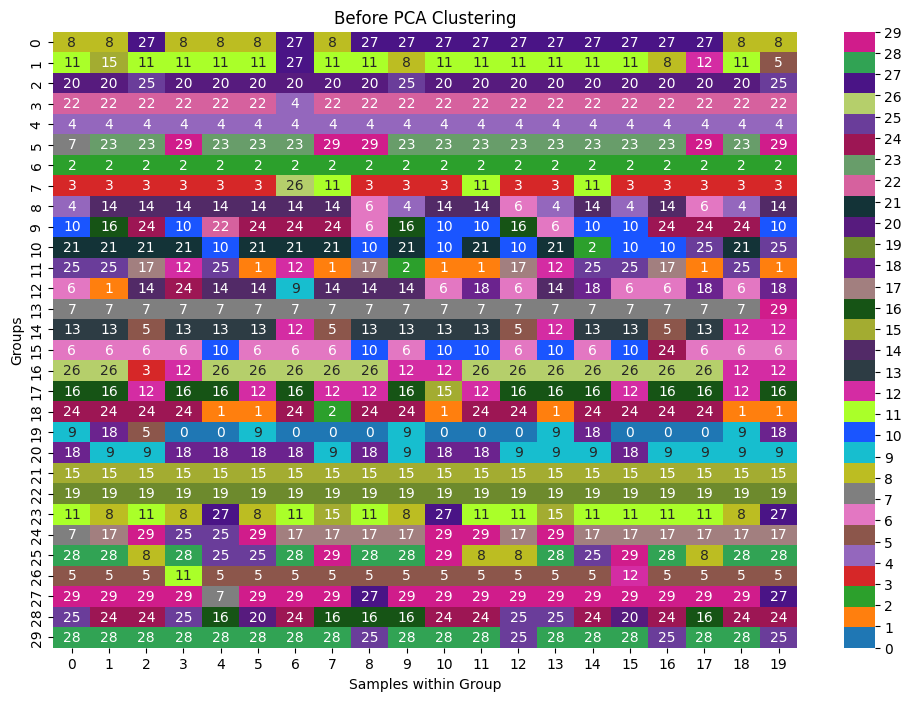

In [447]:
visualize_results(clusters_before_PCA,"Before PCA Clustering")

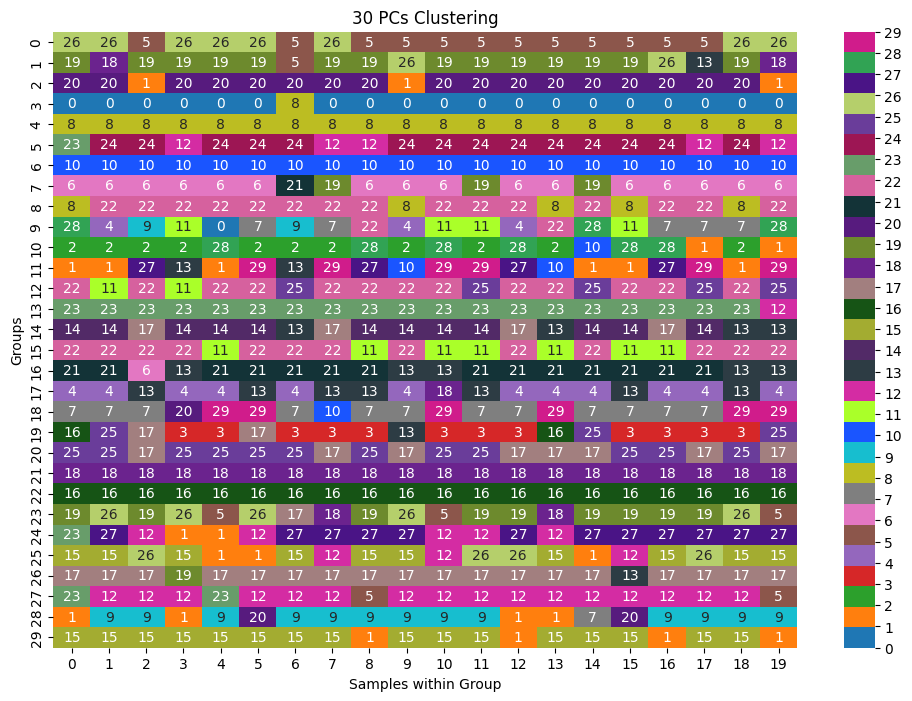

In [438]:
visualize_results(clusters_30PC,"30 PCs Clustering")

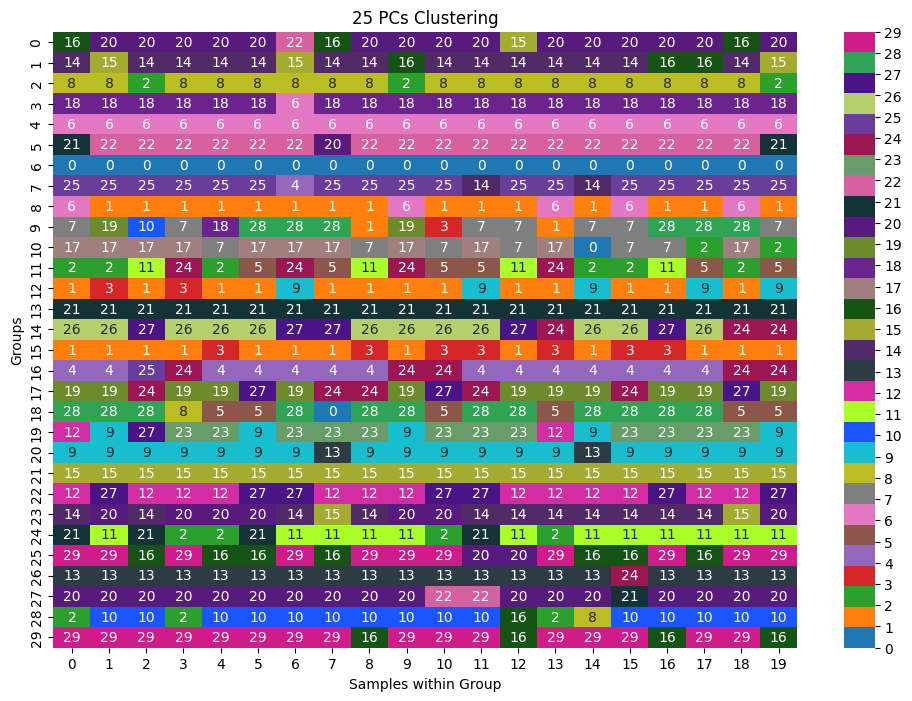

In [439]:
visualize_results(clusters_25PC,"25 PCs Clustering")

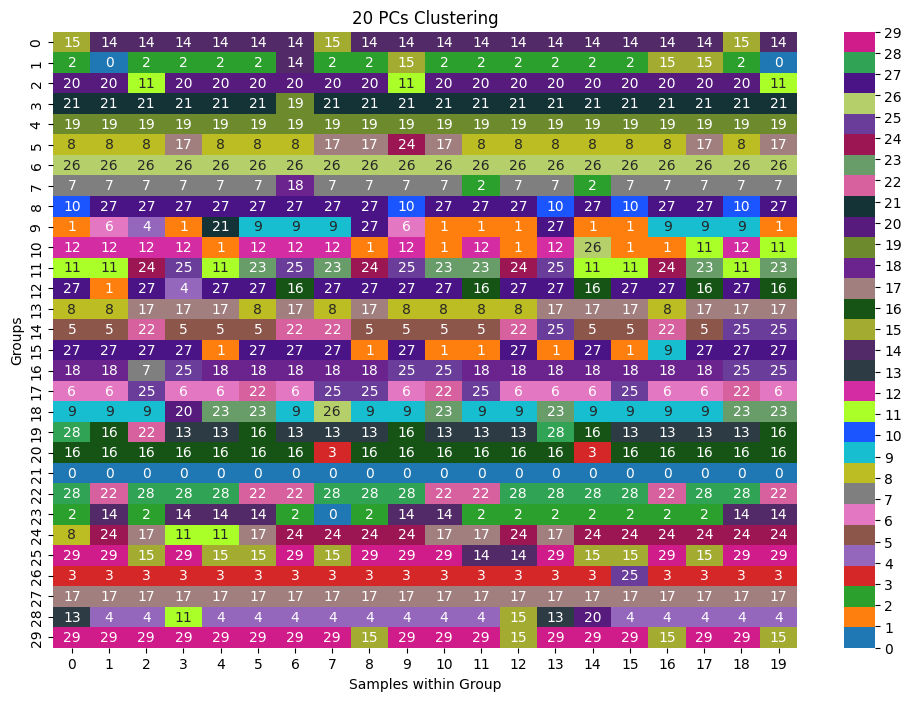

In [440]:
visualize_results(clusters_20PC,"20 PCs Clustering")

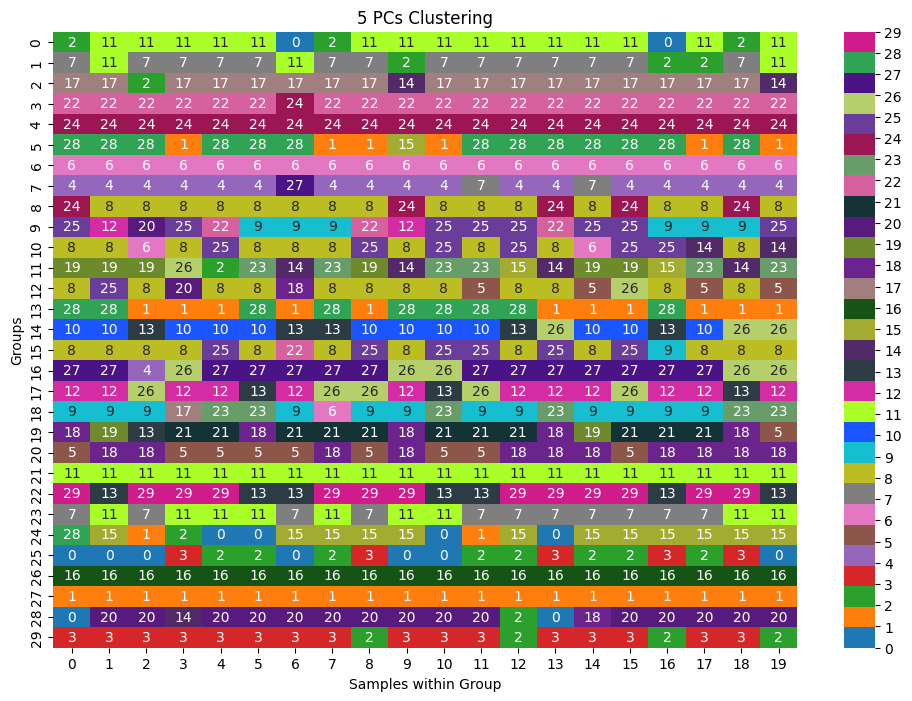

In [441]:
visualize_results(clusters_5PC,"5 PCs Clustering")

---
**FINAL REPORT**
===

* First lets talk about fuzzy c means algorithm, I noticed that itis very good in my clustering problem because i know exact number of clusters the algorithm should perform (Predefined C).
* I used the algorithm to cluster 30 different fruits images each fruit has exact 20 images.
* We noticed that exact 598 PCs has 100% of the data variances so we applied the algorithm 5 times:
  -  before applying PCA
  -  After selecting best **900** Principle components
  -  After selecting best **625** Principle components
  -  After selecting best **400** Principle components
  -  After selecting best **25** Principle components
* Before applying PCA :
  - Time: ~= 18 minuts
  - Results: **Bad** intertia 'effected with high number of features', Good Davies Bounding index but not best, Good visualized results 
* After Applying PCA and selecting best 900 PCs:
  - Time: ~= 4.20 minuts
  - Results:  **Best** intertia, Good Davies-bouldin index, Good visualized results
* After Applying PCA and selecting best 625 PCs:
  - Time: ~= 3.20 minuts
  - Results:  Good intertia, Good Davies-bouldin index, Good visualized resutls
* After Applying PCA and selecting best 400 PCs:
  - Time: ~= 2.20 minuts
  - Results: Good  intertia, Good Davies-bouldin index, Good visualized results
* After Applying PCA and selecting best 25 PCs:
  - Time: ~= 1.20 minuts
  - Results: Relatively **Bad** intertia, **Best** Davies-bouldin index, Mid visualized results

* **Based on all above information, I noticed that reducing num of features using PCA is really worthy but you should choose number of principle components that keeps the variance == 1 in order to help FCM clustering the data, because reducing features too much may cause in get the data losses its informative infromation and get classes near each other and that will make them hard to cluster.**   